First I tried using the `elevation` package, but it only enables downloading a few tiles at a time (and I need to whole world map).  
Also, it only has two resolutions which are pretty high, which makes a huge map. (and of them the lower resolution seems to have a bug and can't be used - but its anyway too big for my needs).  

Thus, follwing this link:  
https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation?qt-science_center_objects=0#qt-science_center_objects  
I downloaded the elevation map from here:  
https://earthexplorer.usgs.gov/  
it offers relatively low res (I chose the lowest), and if needed, more map versions and data can be downloaded from there (once a free user account was created).  

Not done: maybe add mask (e.g. for europe):  
https://jan-46106.medium.com/plotting-maps-with-european-data-in-python-part-i-decd83837de4


In [60]:
#import pyvista as pv
import numpy as np
#import netCDF4 as nc
import gemgis as gg
#import pandas as pd
#import logging
import os
from glob import glob
#import elevation
import matplotlib.pyplot as plt
import zipfile
from skimage.transform import resize
import pandas as pd

from skimage import io
import cv2
import netCDF4 as nc

import pyvista as pv

from matplotlib import cm
from matplotlib import colors


In [2]:
## elevation package:

# elevation.clip(bounds=(-15, 30, -10, 40), 
#                output='Rome-DEM.tif')

### earthexplorer.usgs.gov elevation map

In [3]:
# zip_dir = '/home/ella/Desktop/bulk'
raw_dir = '../../elevation_map_tiles'

# # get all zip files:
# all_zip_files = glob(os.path.join(zip_dir,'*'))
# len(all_zip_files), all_zip_files[0]

# # Unzip
# for f in all_zip_files:
#     with zipfile.ZipFile(f, 'r') as zip_ref:
#         zip_ref.extractall(raw_dir)

In [4]:
paths = gg.raster.create_filepaths(dirpath=raw_dir, search_criteria = '*mea*')
len(paths), paths[0:3]

(107,
 ['/home/ella/work/earth_watch/elevation_map_tiles/70n180w_20101117_gmted_mea300.tif',
  '/home/ella/work/earth_watch/elevation_map_tiles/30s150e_20101117_gmted_mea300.tif',
  '/home/ella/work/earth_watch/elevation_map_tiles/50s030w_20101117_gmted_mea300.tif'])

#### tiles to image with GemGis

In [5]:
raster_objects = gg.raster.create_src_list(filepaths=paths)
raster_objects[0:3]

[<open DatasetReader name='/home/ella/work/earth_watch/elevation_map_tiles/70n180w_20101117_gmted_mea300.tif' mode='r'>,
 <open DatasetReader name='/home/ella/work/earth_watch/elevation_map_tiles/30s150e_20101117_gmted_mea300.tif' mode='r'>,
 <open DatasetReader name='/home/ella/work/earth_watch/elevation_map_tiles/50s030w_20101117_gmted_mea300.tif' mode='r'>]

In [6]:
#mosaic, transform = gg.raster.merge_tiles(src_files=raster_objects)

In [7]:
#mosaic.shape, (mosaic.size * mosaic.itemsize)*0.000001

In [8]:
#(mosaic.size * mosaic.itemsize)*0.000001

In [9]:
# black_val = mosaic[0,0] 
# ocean_val = mosaic[10000,0]

# ## making black into zero (like ocean)
# mosaic[mosaic==black_val] = ocean_val

In [10]:
# plt.imshow(mosaic[:,100:], cmap='gray')

#### tiles to image manually 

In [11]:
metadatas = [os.popen(f'gdalinfo {p}').read().split('\n') for p in paths]

In [12]:
ULs = ["".join(m).split('Upper Left')[1].split('(')[1].split(')')[0] for m in metadatas]
LLs = ["".join(m).split('Lower Left')[1].split('(')[1].split(')')[0] for m in metadatas]
URs = ["".join(m).split('Upper Right')[1].split('(')[1].split(')')[0] for m in metadatas]
LRs = ["".join(m).split('Lower Right')[1].split('(')[1].split(')')[0] for m in metadatas]

In [13]:
df = pd.DataFrame()

df["upper_left_long"] = [float(ul.split(',')[0]) for ul in ULs]
df["upper_left_lat"] = [float(ul.split(',')[1]) for ul in ULs]

df["lower_left_long"] = [float(ll.split(',')[0]) for ll in LLs]
df["lower_left_lat"] = [float(ll.split(',')[1]) for ll in LLs]

df["upper_right_long"] = [float(ur.split(',')[0]) for ur in URs]
df["upper_right_lat"] = [float(ur.split(',')[1]) for ur in URs]

df["lower_right_long"] = [float(lr.split(',')[0]) for lr in LRs]
df["lower_right_lat"] = [float(lr.split(',')[1]) for lr in LRs]

df["name"] = [os.path.basename(p).split('_')[0] for p in paths]

In [14]:
df.head()

,upper_left_long,upper_left_lat,lower_left_long,lower_left_lat,upper_right_long,upper_right_lat,lower_right_long,lower_right_lat,name
0,-180.00,90.00,-180.00,70.00,-150.00,90.00,-150.00,70.00,70n180w
1,150.00,-10.00,150.00,-30.00,180.00,-10.00,180.00,-30.00,30s150e
2,-30.00,-30.00,-30.00,-50.00,-0.00,-30.00,-0.00,-50.00,50s030w
3,-30.00,30.00,-30.00,10.00,-0.00,30.00,-0.00,10.00,10n030w
4,120.00,90.00,120.00,70.00,150.00,90.00,150.00,70.00,70n120e


so the name of the tile is the lower left.  
so west and south are minus.

In [15]:
uniq_ll_long = sorted(np.round(np.unique(df.lower_left_long)))
uniq_ll_lat = list(reversed(sorted(np.round(np.unique(df.lower_left_lat)))))

uniq_ll_long, list(uniq_ll_lat)

([-180.0,
  -150.0,
  -120.0,
  -90.0,
  -60.0,
  -30.0,
  -0.0,
  30.0,
  60.0,
  90.0,
  120.0,
  150.0],
 [70.0, 50.0, 30.0, 10.0, -10.0, -30.0, -50.0, -70.0, -90.0])

In [16]:
## tile size:

for p in paths[0:1]:
    im = io.imread(p)
    #print(im.shape)

#all are the same size...
im.shape, im.dtype

((2400, 3600), dtype('int16'))

In [17]:
## lat, long
world_shape = (21600, 43200)
tile_shape = (2400, 3600)

world_shape[0]/tile_shape[0]

9.0

In [18]:
tiled = np.zeros(world_shape, dtype=np.int16)

for i,y in enumerate(uniq_ll_lat):
    for j,x in enumerate(uniq_ll_long):
        df_tile = df[(df.lower_left_lat.round()==y) & (
            df.lower_left_long.round()==x)]
        if df_tile.shape[0]==1:
            path = [p for p in paths if df_tile.iloc[0]["name"] in p][0]
            
            tiled[i*tile_shape[0]:
                  i*tile_shape[0]+tile_shape[0], 
                  j*tile_shape[1]:
                  j*tile_shape[1]+tile_shape[1]] = io.imread(path)

In [19]:
np.unique(tiled)

array([-32768,   -430,   -412, ...,   8540,   8611,   8625], dtype=int16)

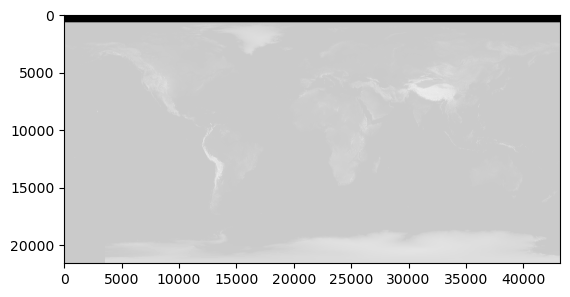

In [20]:
plt.imshow(tiled, cmap='gray')

In [21]:
np.save('elevtion_tiled.npy', tiled)

In [22]:
## every pixel size is:
180/world_shape[0], 360/world_shape[1]

(0.008333333333333333, 0.008333333333333333)

#### align to netCDF europe dataset

In [23]:
ds = nc.Dataset('../../UFZ_RemoteSensing/HOLAPS-H-JJA_anomaly-d-2001-2005.nc')
heat = np.flip(ds["surface_upward_sensible_heat_flux"][0], axis=0)
lat_arr = ds['latitude'][:]
long_arr = ds['longitude'][:]

In [24]:
tiled_loc_lat = np.linspace(-90, 90, tiled.shape[0])
tiled_loc_long = np.linspace(-180, 180, tiled.shape[1])

In [25]:
min_lat = np.min(lat_arr)
max_lat = np.max(lat_arr)
min_long = np.min(long_arr)
max_long = np.max(long_arr)

min_lat, max_lat, min_long, max_long

(30.0, 60.0, -15.0, 46.9696)

In [26]:
def find_idx_nearest_val(arr, val):
    return (np.abs(arr - val)).argmin()

In [27]:
world_max_lat_idx = find_idx_nearest_val(-tiled_loc_lat, min_lat)
world_min_lat_idx = find_idx_nearest_val(-tiled_loc_lat, max_lat)

world_min_long_idx = find_idx_nearest_val(tiled_loc_long, min_long)
world_max_long_idx = find_idx_nearest_val(tiled_loc_long, max_long)

world_min_lat_idx, world_max_lat_idx, world_min_long_idx, world_max_long_idx

(3600, 7200, 19800, 27236)

In [28]:
europe = tiled[world_min_lat_idx:world_max_lat_idx, world_min_long_idx:world_max_long_idx]

In [29]:
europe = np.load('europe.npy')

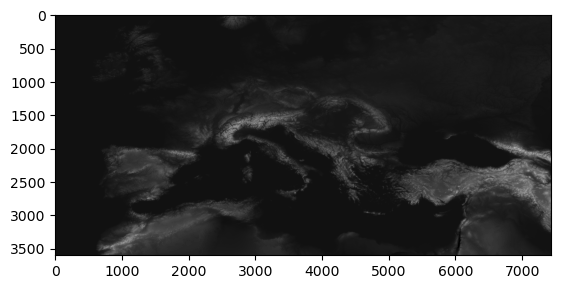

In [30]:
plt.imshow(europe, cmap='gray')

In [32]:
# add boarders:
borders = io.imread('borders_europe.png')
borders = cv2.cvtColor(borders, cv2.COLOR_RGBA2GRAY)

In [33]:
europe.shape, borders.shape, heat.shape

((3600, 7436), (750, 1550), (601, 1233))

In [34]:
shap = (2000,4000)

In [35]:
europe_resized = cv2.resize(europe, shap[::-1], interpolation=cv2.INTER_NEAREST)
borders_resized = cv2.resize(borders, shap[::-1], interpolation=cv2.INTER_AREA)
heat_resized = cv2.resize(heat, shap[::-1], interpolation=cv2.INTER_NEAREST)

In [44]:
europe_resized[borders_resized<200] = 0

In [45]:
heat_resized[heat_resized<-1000] = 0

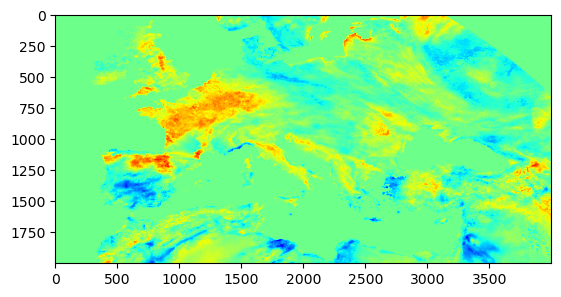

In [46]:
plt.imshow(heat_resized, cmap=('jet'))

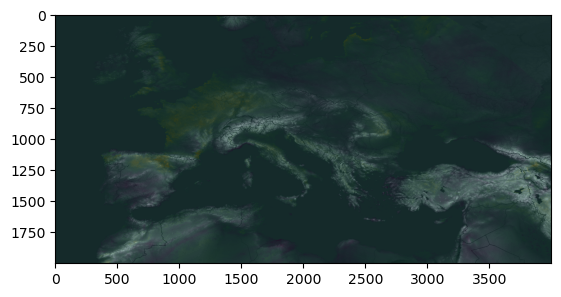

In [47]:
plt.imshow(europe_resized, cmap='gray')
plt.imshow(heat_resized, alpha=0.2)

In [48]:
np.unique(europe_resized)

array([-412, -411, -407, ..., 5160, 5197, 5419], dtype=int16)

In [49]:
np.min(borders_resized), np.max(borders_resized)

(0, 255)

In [50]:
arr = europe_resized.copy().astype(np.int16)

scale = 0.01
arr = arr*scale
arr[arr==0] = -999
arr = np.flip(arr, axis=0)
np.unique(arr, return_counts=True)

(array([-999.  ,   -4.12,   -4.11, ...,   51.6 ,   51.97,   54.19]),
 array([3228926,       3,       1, ...,       1,       1,       1]))

In [55]:
grid = gg.visualization.create_dem_3d(dem=arr, extent=[0, arr.shape[1], 0, arr.shape[0]])
unstructured_grid = grid.threshold(-500, invert=False, preference='point', all_scalars=True)
surface = unstructured_grid.extract_geometry()
surface = surface.smooth(n_iter=500)


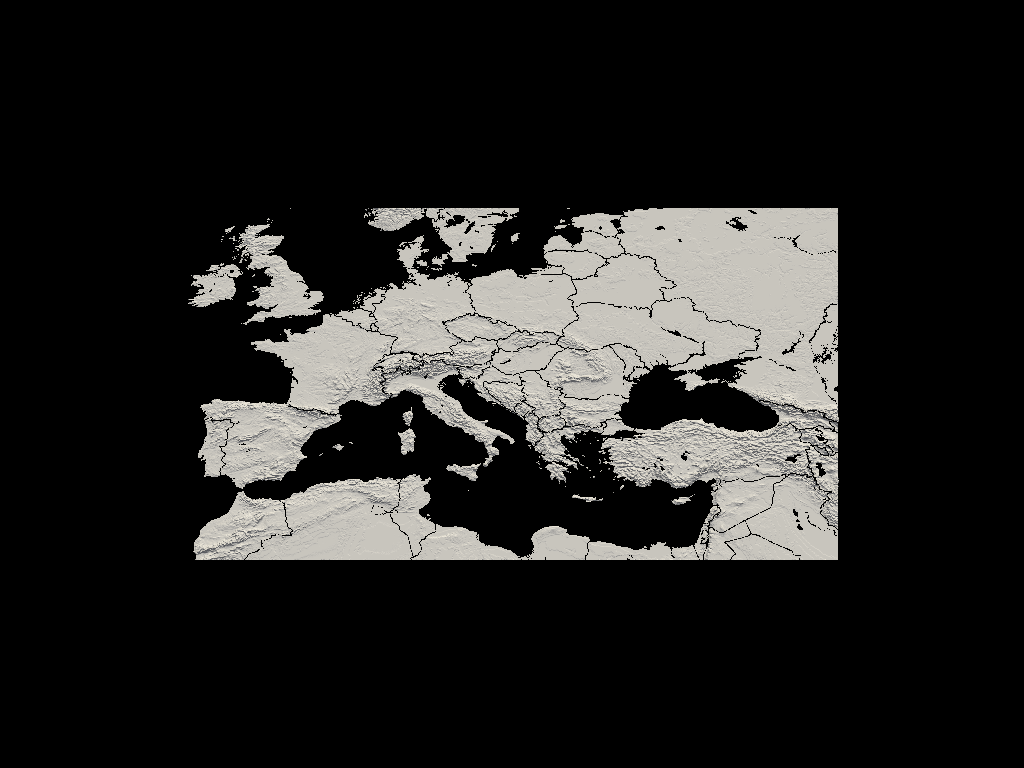

In [56]:
# Create render engine:
p = pv.Plotter()
# multi_sample mitigates aliasing - higher is better, but might affect performance.
# Open up an MP4 output file

p.set_background('black')

p.add_mesh(mesh=surface, name='mesh', color='white')

p.camera_position = 'xy'

p.show()


In [75]:
np.unique(heat_resized)

array([-111.63459 , -107.13638 ,  -99.7192  , ...,  114.48743 ,
        114.66737 ,  119.272026], dtype=float32)

In [76]:
h = heat_resized
hh = (h + 118)
hh[hh==np.min(hh)] = 0
hh = hh.astype(np.uint8)
np.unique(hh)

array([  0,  10,  18,  19,  21,  22,  24,  25,  26,  27,  28,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 19

In [77]:
colmap = cm.get_cmap('jet')
if isinstance(colmap, colors.LinearSegmentedColormap):
    colmap = colmap(np.arange(0,colmap.N))*np.asarray([255,255,255,0.5*255]).astype(np.uint8)

colmap[0] = [255,255,255,0]

for i in range(1,127):
    colmap[i,3] = 255-i*2
    colmap[255-i,3] = 255-i*2

result = np.zeros((*shap,4), dtype=np.uint8)

b = np.take(colmap, hh, axis=0, out=result)

In [78]:
# # Create the ground control points for texture mapping
# o = ds.x.min(), ds.y.min(), 0.0 # Bottom Left
# u = ds.x.max(), ds.y.min(), 0.0 # Bottom Right
# v = ds.x.min(), ds.y.max(), 0.0 # Lop left
# Note: Z-coordinate doesn't matter

o = 0, 0, 0.0 # Bottom Left
u = 4000, 0, 0.0 # Bottom Right
v = 0, 2000, 0.0 # Lop left

# Use the GCPs to map the tex coords
mapped_surface = surface.texture_map_to_plane(o, u, v)

# Associate the texture with the mapped mesh
mapped_surface.textures["aerial"] = pv.numpy_to_texture(b)

# Plot it up in 3D and enjoy!
#mapped_surface.plot(texture="aerial", notebook=0)

/home/ella/mambaforge/envs/pyvista_basemap/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


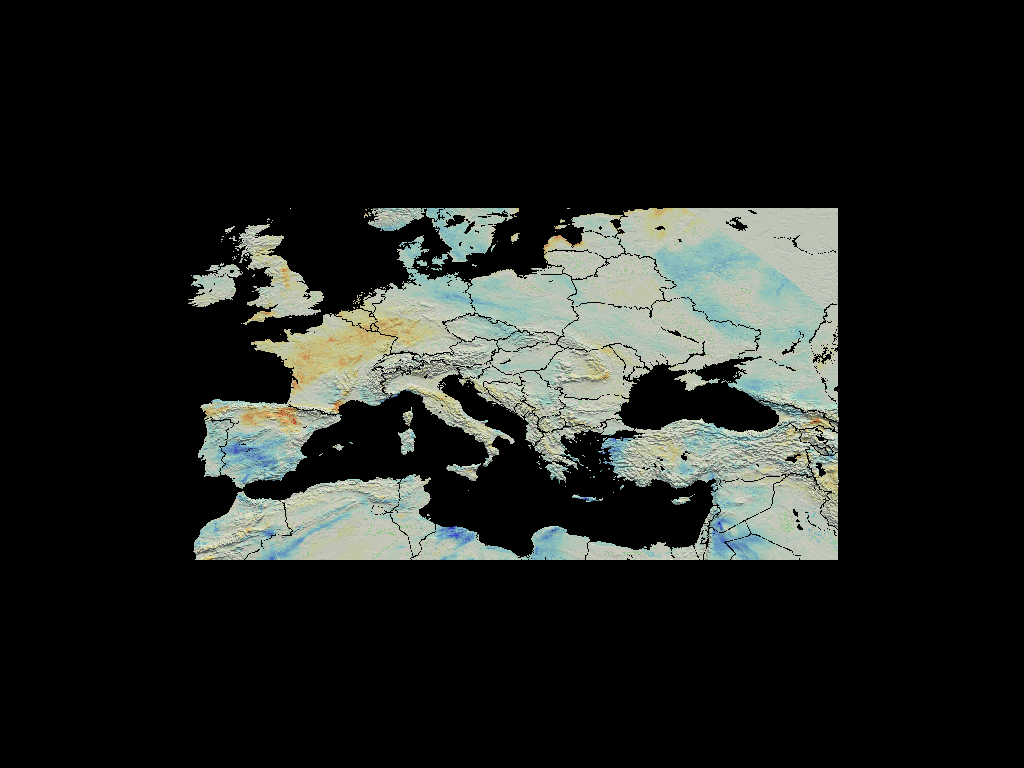

In [79]:
# Create render engine:
p = pv.Plotter()
# multi_sample mitigates aliasing - higher is better, but might affect performance.
# Open up an MP4 output file

p.set_background('black')

p.add_mesh(mesh=surface, name='mesh1', color='white',
           smooth_shading=True)#, scalar_bar_args={"color": "black"})

p.add_mesh(mesh=mapped_surface, name='mesh', 
           smooth_shading=True)#, scalar_bar_args={"color": "black"})

#p.add_background_image(heat) 

p.camera_position = 'xy'

p.show()